In [1]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA

import matplotlib.image as image
import matplotlib.pyplot as plt

# Wczytanie obrazka

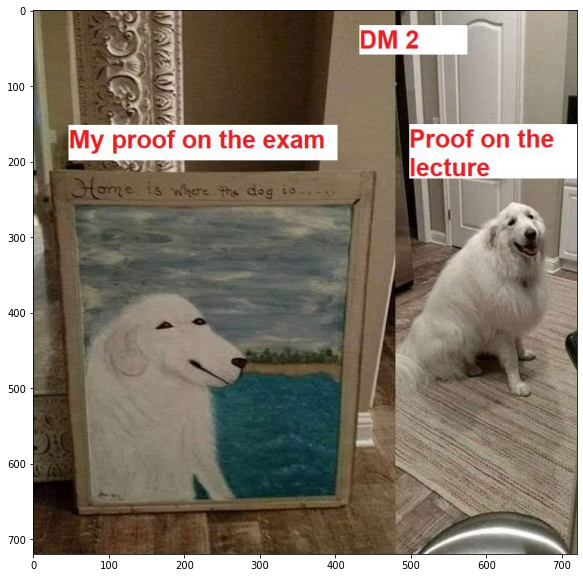

In [2]:
x = image.imread('md2.png')
fig = plt.figure(figsize=(10, 10))
plt.imshow(x);

Wymiary przed zmianą

In [3]:
x.shape

(720, 720, 3)

## Konwersja na macierz 2D

In [4]:
x_arr = np.reshape(x, (720, 720 * 3))
x_arr.shape

(720, 2160)

# PCA

In [5]:
pca = PCA(100)
pca.fit(x_arr)
x_pca = pca.transform(x_arr)

In [6]:
x_pca.shape

(720, 100)

In [7]:
print('Zmiana w wielkości macierzy = {}'.format((x_arr.nbytes)/x_pca.nbytes))

Zmiana w wielkości macierzy = 21.6


Dla wygody stwórzmy funkcję, która kompresuje powyższy obrazek z argumentem n_components

In [8]:
def compress(n_comp):
    """
    Kompresuje macierz x_arr do obrazka ret
    """
    
    pca = PCA(n_comp)
    pca.fit(x_arr)
    x_pca = pca.transform(x_arr)
    ret = pca.inverse_transform(x_pca)
    ret = np.reshape(ret, (720,720,3)) 
    return ret

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'n_components=10')

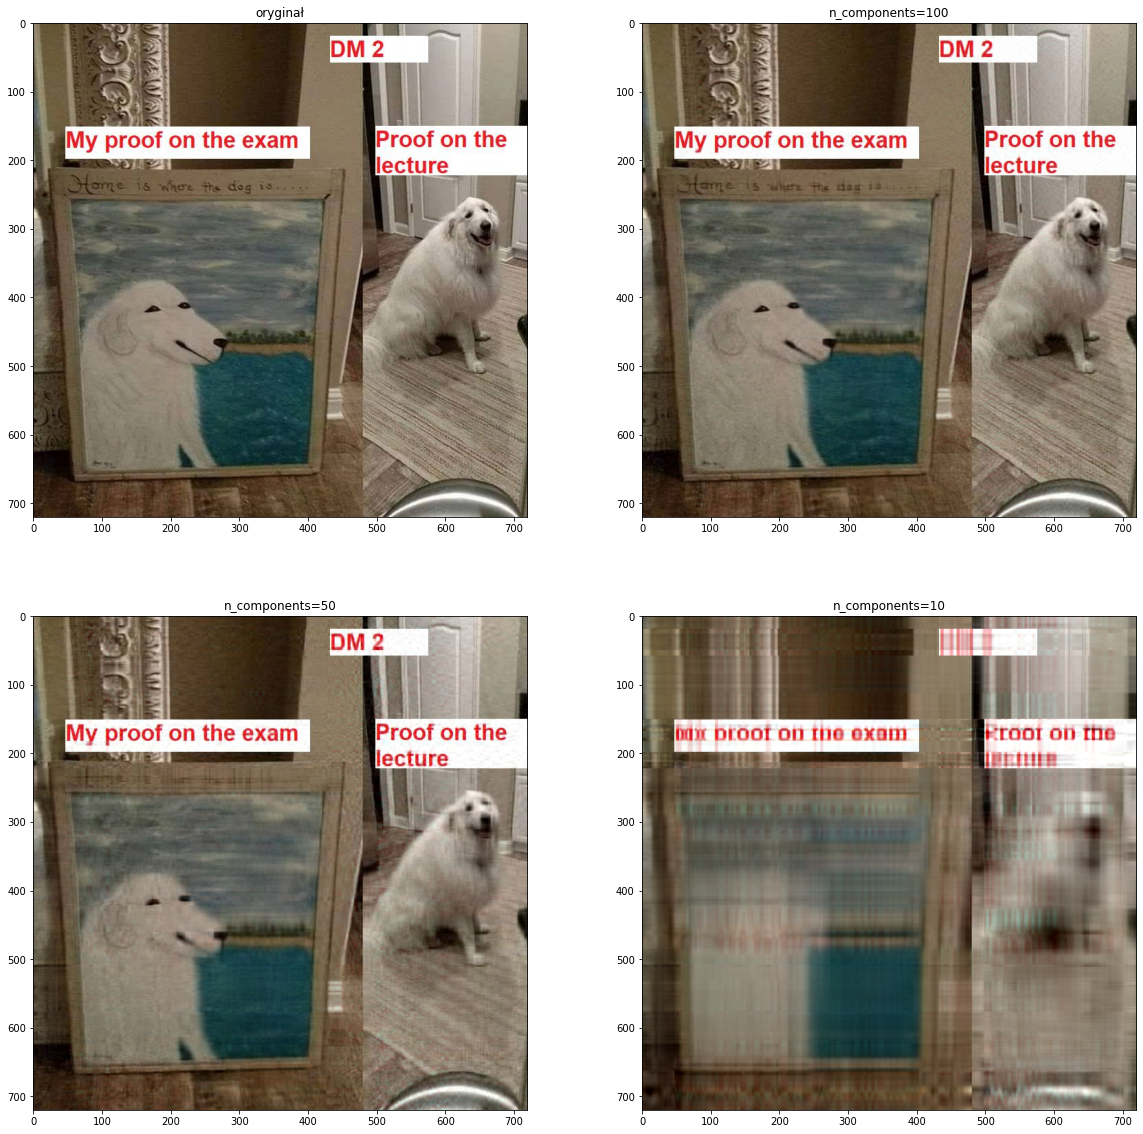

In [9]:
f, axarr = plt.subplots(2,2, figsize=(20,20))
axarr[0,0].imshow(x)
axarr[0,0].set_title("oryginał")

axarr[0,1].imshow(compress(100))
axarr[0,1].set_title("n_components=100")

axarr[1,0].imshow(compress(50))
axarr[1,0].set_title("n_components=50")

axarr[1,1].imshow(compress(10))
axarr[1,1].set_title("n_components=10")

Jak widać udało nam się całkiem nieźle skompresować obrazek:

 * dla 100 komonentów kompresja sprawia, że obrazek zajmuje ok. 21 razy mniej miejsca
 * jakość jest nieco gorsza, jednak sens obrazka nadal jest zachowany
 * MD2 nadal jest trudnym przedmiotem, dobrze że nie jest obowiązkowy dla danonków

# Zmiany rozmiaru
Zobaczmy jak ma się ilość komponentów do oszczędności na miejscu

In [10]:
ratio = []
for i in range(1,720,10):
    pca = PCA(i)
    pca.fit(x_arr)
    x_pca = pca.transform(x_arr)
    ratio.append( x_arr.nbytes/x_pca.nbytes )

Text(0.5, 0, 'n_components')

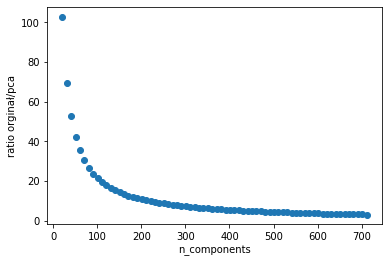

In [11]:
plt.scatter(range(1,720,10)[2:], ratio[2:])
plt.ylabel("ratio orginał/pca")
plt.xlabel("n_components")

Można było się tego spodziewać - im większa kompresja tym więcej miejsca zaoszczędzimy

# Bonus

In [12]:
from sklearn.decomposition import FastICA

df = pd.read_table("../../signals.tsv")
df

,time,signal1,signal2,signal3,signal4
0,0,0.493428,0.078710,-1.314636,1.193460
1,1,0.524618,0.791259,-1.321386,-0.075256
2,2,-0.024396,1.064251,-1.582284,0.785229
3,3,0.219586,1.007421,-1.481651,0.193773
4,4,0.426865,0.943133,-1.521795,-0.433458
...,...,...,...,...,...
9995,9995,-0.448773,-1.111182,1.695837,-0.249654
9996,9996,-1.017297,-1.054893,1.696765,0.547200
9997,9997,-0.189845,-0.915049,1.544527,0.000046
9998,9998,-0.563954,-0.785451,1.825540,-0.775807


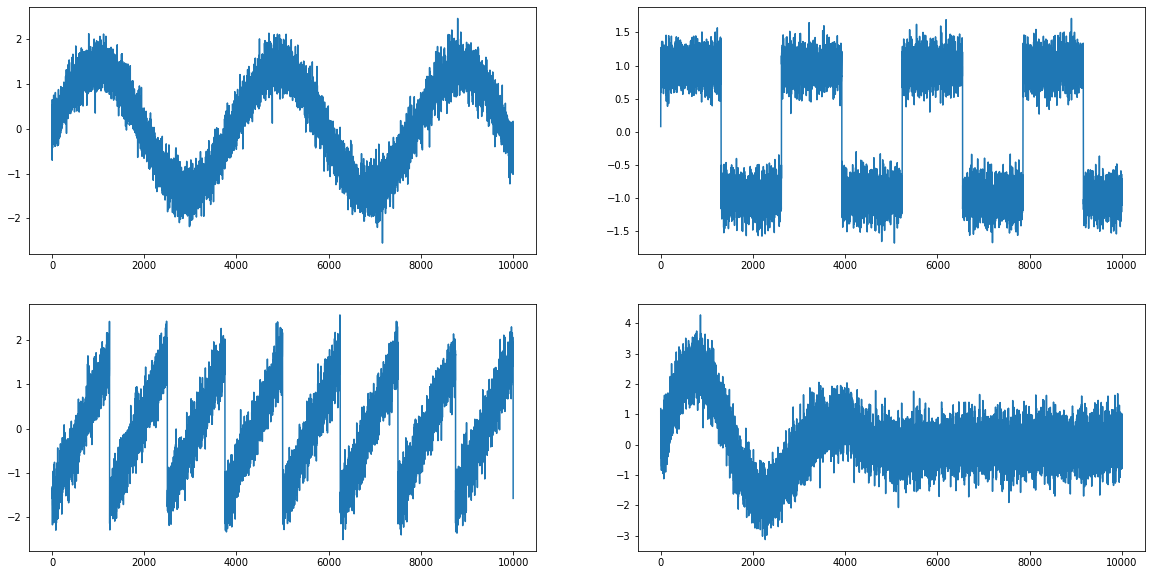

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax[0, 0].plot(df.time, df.signal1)
ax[0, 1].plot(df.time, df.signal2)
ax[1, 0].plot(df.time, df.signal3)
ax[1, 1].plot(df.time, df.signal4)

Sygnały są pozamieniane miejscami w wyniku ICA, więc od razu to naprawimy

In [14]:
ica = FastICA(n_components=4,random_state=1234)
df_trans = ica.fit_transform(df.iloc[:, 1:5])

df_ica = pd.DataFrame({'time': df.time,
                       'signal1': df_trans.T[0],
                       'signal2': df_trans.T[2],
                       'signal3': df_trans.T[3],
                       'signal4': df_trans.T[1]})

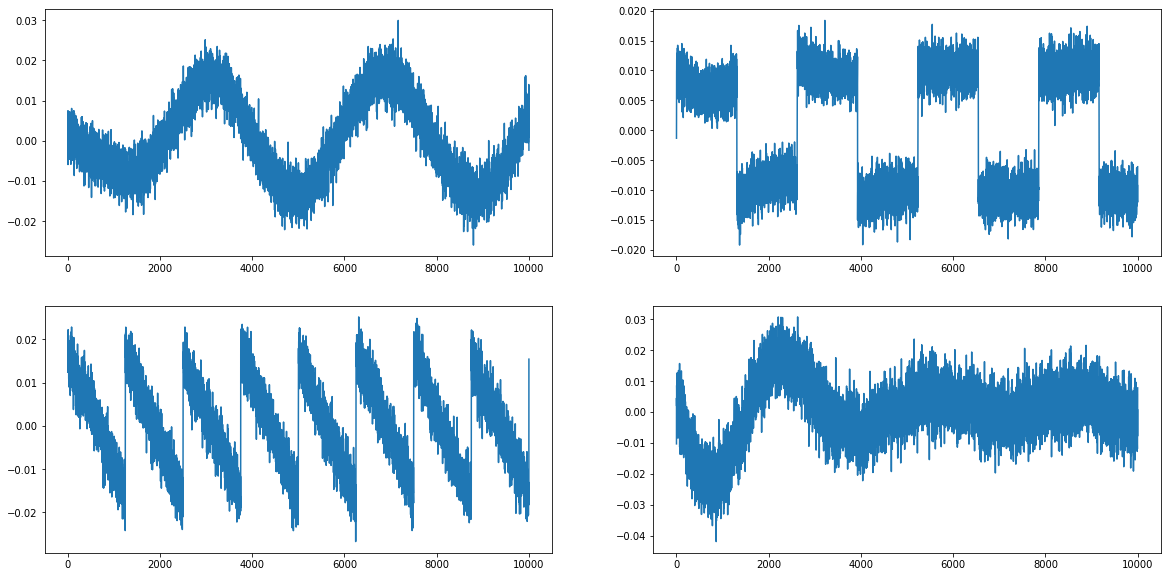

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax[0, 0].plot(df_ica.time, df_ica.signal1)
ax[0, 1].plot(df_ica.time, df_ica.signal2)
ax[1, 0].plot(df_ica.time, df_ica.signal3)
ax[1, 1].plot(df_ica.time, df_ica.signal4)

Spójrzmy jeszcze czy korelacje faktycznie uległy zmianie:

In [16]:
# Przed
df.iloc[:,1:5].corr()

,signal1,signal2,signal3,signal4
signal1,1.000000,0.082866,-0.018906,0.321826
signal2,0.082866,1.000000,-0.048733,0.318839
signal3,-0.018906,-0.048733,1.000000,0.008120
signal4,0.321826,0.318839,0.008120,1.000000


In [17]:
# Po
df_ica.iloc[:,1:5].corr()

,signal1,signal2,signal3,signal4
signal1,1.000000e+00,1.223326e-15,3.297601e-16,-8.372751e-16
signal2,1.223326e-15,1.000000e+00,9.715265e-16,1.124284e-15
signal3,3.297601e-16,9.715265e-16,1.000000e+00,1.899522e-16
signal4,-8.372751e-16,1.124284e-15,1.899522e-16,1.000000e+00


Praktycznie nie są skorelowane.

## Oświadczenie
Oświadczam, że niniejsza praca stanowiąca podstawę do uznania osiągnięcia efektów uczenia się z przedmiotu _Wstęp do Uczenia Maszynowego_ została wykonana przeze mnie samodzielnie.

Hanna Zdulska(298852)